In [1]:
import torch
import torch.nn as nn
import torchmetrics

from datetime import date

import sys; sys.path.append("../")
from models.model_SimpleUNet import SimpleUnet

from utils import (
    load_data,
    training_loop,
    TiledMSE,
    data_protocol_bd
)


In [2]:
# define training hyper-parameters 
LEARNING_RATE = 0.0001
NUM_EPOCHS = 100
BATCH_SIZE = 64
num_workers = 6
augmentations = False

In [3]:
# define dataset folder 
DATA_FOLDER = '/home/lcamilleri/data/s12_buildings/data_patches/'

In [4]:
# define model & criterion
model =  SimpleUnet(input_dim=10, output_dim=1) 
criterion = nn.MSELoss() 
lr_scheduler = 'reduce_on_plateau'

In [5]:
# define save folder location
NAME = model.__class__.__name__
OUTPUT_FOLDER = f'trained_models/{date.today().strftime("%d%m%Y")}_{NAME}_aug={augmentations}'
if lr_scheduler is not None:
    OUTPUT_FOLDER = f'trained_models/{date.today().strftime("%d%m%Y")}_{NAME}_aug={augmentations}_{lr_scheduler}'
    if lr_scheduler == 'reduce_on_plateau':
        LEARNING_RATE = LEARNING_RATE / 100000 # for warmup start

In [6]:
# attach model to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
# create a dataset
# split_percentage defines the % of samples taken from 
# each specified region ... example split_percentage = 0.2 
# will create a training set consisting of only 20% of the 
# images from each region.

x_train, y_train, x_val, y_val, x_test, y_test = data_protocol_bd.protocol_split(folder=DATA_FOLDER,
                                                                                     split_percentage=1)


In [8]:
# create dataloaders for training
dl_train, dl_val, dl_test = load_data(x_train, y_train, x_val, y_val, x_test, y_test,
                                      with_augmentations=augmentations,
                                      num_workers=num_workers,
                                      batch_size=BATCH_SIZE,
                                      encoder_only=False,
                                      )

In [9]:
# define some torch metrics
wmape = torchmetrics.WeightedMeanAbsolutePercentageError(); wmape.__name__ = "wmape"
mae = torchmetrics.MeanAbsoluteError(); mae.__name__ = "mae"
mse = torchmetrics.MeanSquaredError(); mse.__name__ = "mse"

In [10]:
# run training loop
training_loop(
        num_epochs=NUM_EPOCHS,
        learning_rate=LEARNING_RATE,
        model=model,
        criterion=criterion,
        device=device,
        metrics=[
            mse.to(device),
            wmape.to(device),
            mae.to(device),
        ],
        lr_scheduler=lr_scheduler,
        train_loader=dl_train,
        val_loader=dl_val,
        test_loader=dl_test,
        name=NAME,
        out_folder=OUTPUT_FOLDER,
        predict_func=None,
    )

Starting training...



Epoch 5/100: 100%|██████████████████████████████████████████████████████| 598/598 [00:23<00:00, 25.23it/s, loss=0.0501, mse=0.0501, wmape=1.0837, mae=0.1390, val_loss=0.0409, val_mse=0.0409, val_wmape=1.0125, val_mae=0.1194, lr=1e-5]


Warmup finished


Epoch 100/100: 100%|████████████████████████████████████████████████████| 598/598 [00:35<00:00, 16.65it/s, loss=0.0136, mse=0.0136, wmape=0.4422, mae=0.0568, val_loss=0.0196, val_mse=0.0196, val_wmape=0.5574, val_mae=0.0674, lr=1e-6]


Finished Training. Best epoch:  79

Starting Testing...
Test Accuracy: 0.0168


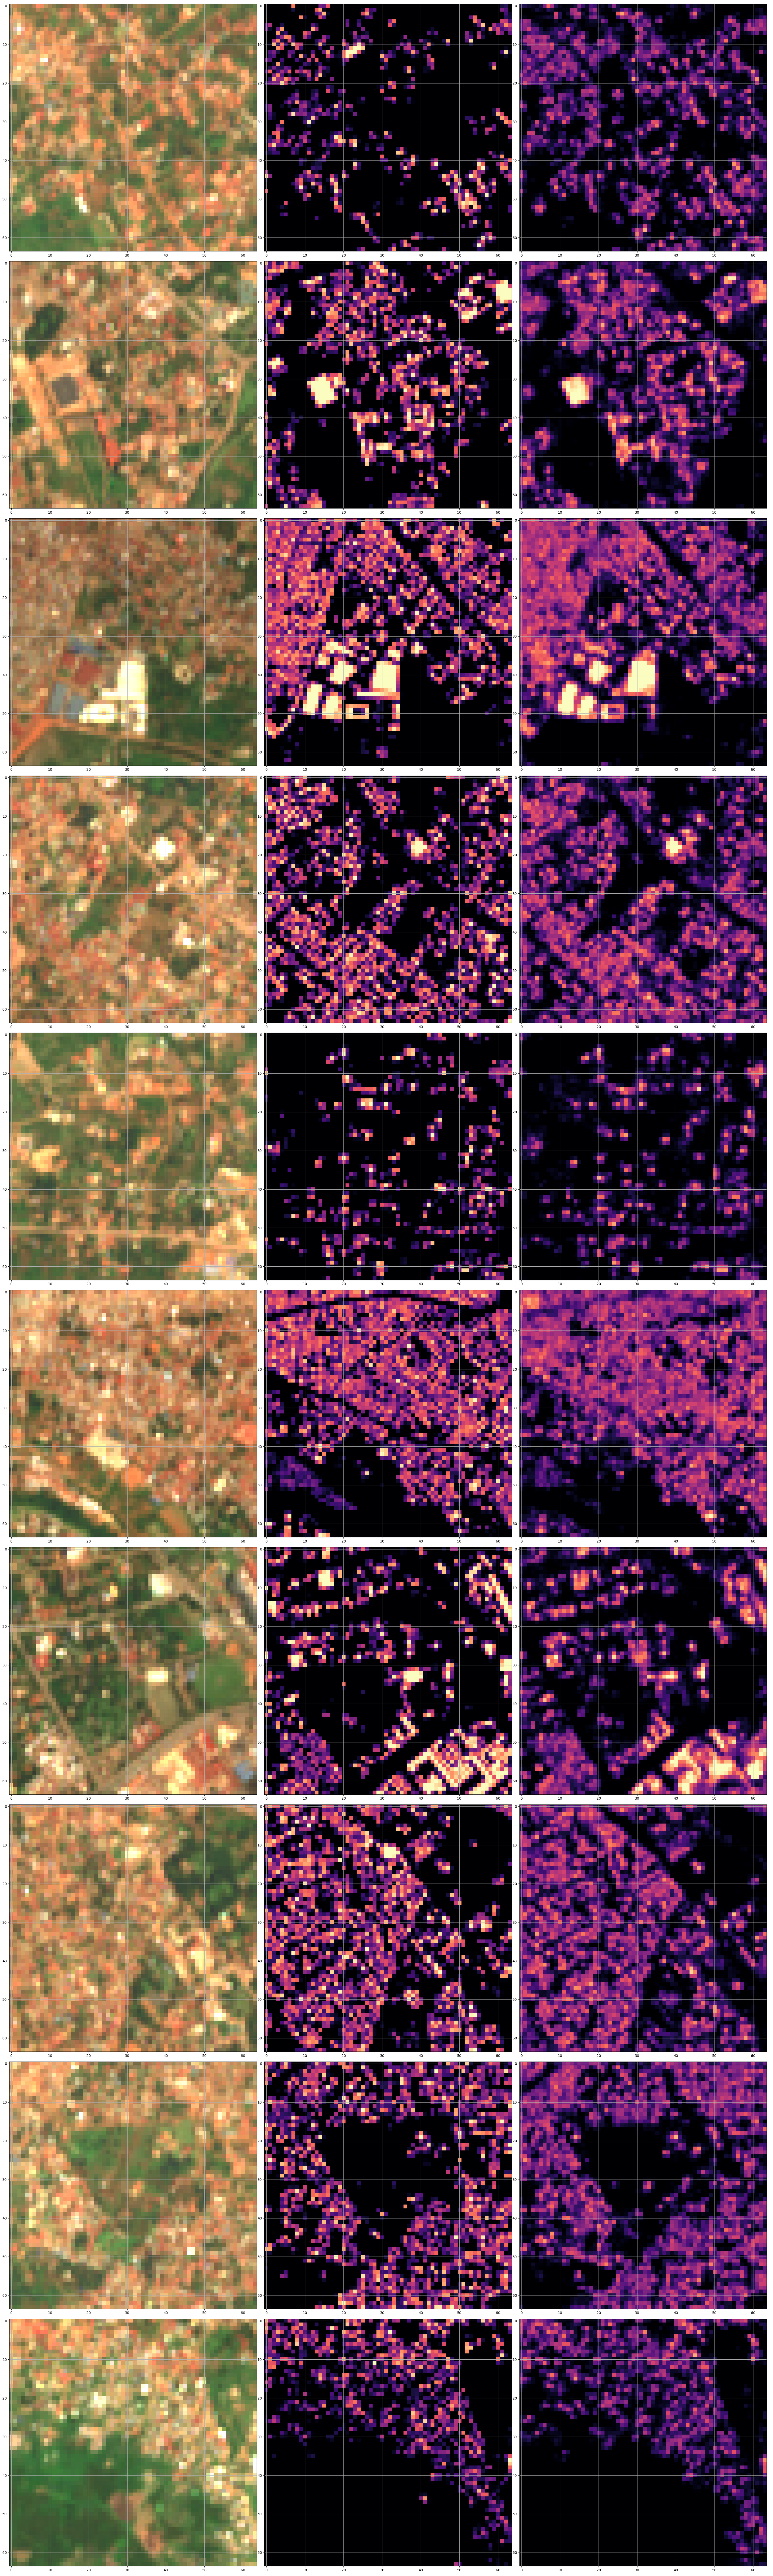

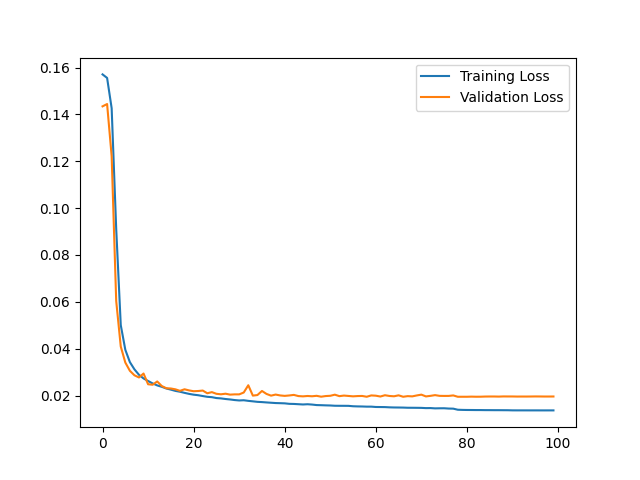

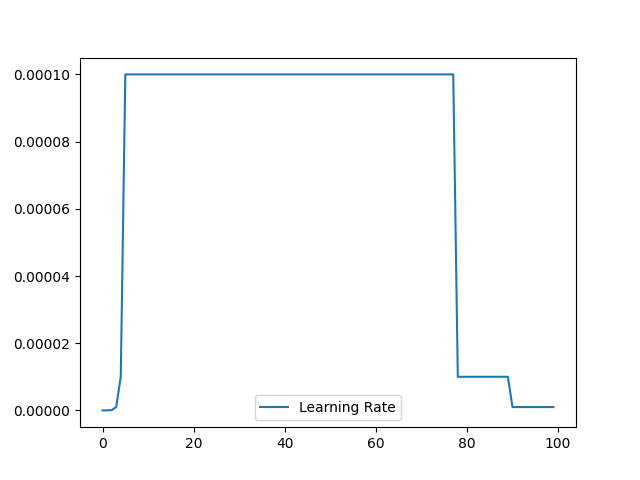

In [11]:
from IPython.display import display, Image
display(Image(filename= f'{OUTPUT_FOLDER}/visualisations/test_pred.png'))
display(Image(filename= f'{OUTPUT_FOLDER}/loss.png'))
display(Image(filename= f'{OUTPUT_FOLDER}/lr.png'))